In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
df_train = pd.read_csv('/content/drive/MyDrive/ML/HAI817_Projet_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/ML/HAI817_Projet_test.csv')

In [11]:
# Importation des différentes librairies, classes et fonctions utilespour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# librairies générales
import pandas as pd
import re
from tabulate import tabulate
import time
import numpy as np
import pickle
import string
import base64
import sys

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns

# librairies scikit learn
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


# librairies des classifiers utilisés
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# librairies NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize 

 
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Concaténation des 2 df

In [13]:
df_all = pd.concat([df_train,df_test])
df_all.head(10)


,public_id,text,title,our rating,ID
0,5a228e0e,Distracted driving causes more deaths in Canad...,"You Can Be Fined $1,500 If Your Passenger Is U...",false,NaN
1,30c605a1,Missouri politicians have made statements afte...,Missouri lawmakers condemn Las Vegas shooting,mixture,NaN
2,c3dea290,Home Alone 2: Lost in New York is full of viol...,CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...,mixture,NaN
3,f14e8eb6,But things took a turn for the worse when riot...,Obama’s Daughters Caught on Camera Burning US ...,false,NaN
4,faf024d6,It’s no secret that Epstein and Schiff share a...,Leaked Visitor Logs Reveal Schiff’s 78 Visits ...,false,NaN
5,c03ed5db,Nation UPDATED 8:23 PM - K A B O O M! Governo...,K A B O O M! Governor and Secretary of State i...,other,NaN
6,61bd9a69,"November 23, 2019 The U.S. Food and Drug Admi...",FDA Shocking Study: Cells Used In Vaccines Con...,false,NaN
7,bb1999cc,"Trump confirms this was a bombing, not an acci...","Israel Hits Beirut with Nuclear Missile, Trump...",false,NaN
8,c1dc1ac6,In a show of anti-American sentiment that will...,Obama’s Daughters Caught on Camera Burning US ...,false,NaN
9,f2182a54,"FEMA camps, portable human cages, it's all rea...",Fields of human cages discovered in Caruthers ...,false,NaN


Vérification d'existence des valeurs nulls 

In [14]:
# compter les valeurs manquantes dans chaque colonne
num_missing_values = df_all.isna().sum()
print(num_missing_values)

public_id      612
text             0
title           23
our rating       0
ID            1264
dtype: int64


Supression des classes : mixture et other 


In [15]:
df_all = df_all[~df_all['our rating'].isin(['mixture', 'other'])]


Encodage des classes true et false

In [16]:


df_all['classe'] = df_all['our rating'].map({'true': 1, 'false': 2})

vérification de désiquilibrage des classes 

In [17]:
print(df_all["classe"].value_counts())

2    893
1    421
Name: classe, dtype: int64


Equilibrage des classes

In [18]:
from sklearn.utils import resample
import pandas as pd



# Séparer les classes majoritaires et minoritaires
df_majority = df_all[df_all['classe'] == 2]
df_minority = df_all[df_all['classe'] == 1]

# Sous-échantillonner la classe majoritaire
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # Échantillonnage sans remplacement
                                   n_samples=len(df_minority), # Nombre d'échantillons égal à la classe minoritaire
                                   random_state=42)  # Pour la reproductibilité

# Combiner les classes majoritaire et minoritaire
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Afficher la taille du jeu de données équilibré
print("Taille du jeu de données équilibré : ", df_balanced.shape)

df_all = df_balanced
print(df_all['classe'].value_counts())

Taille du jeu de données équilibré :  (842, 6)
2    421
1    421
Name: classe, dtype: int64


Définition de la fonction  MyCleanText

In [19]:
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def MyCleanText(X,
 lowercase=False, # mettre en minuscule
 removestopwords=False, # supprimer les stopwords
 removedigit=False, # supprimer les nombres
 getstemmer=False, # conserver la racine des termes
 getlemmatisation=False # lematisation des termes
 ):
    
    sentence = str(X)
    
    # suppression des caractères spéciaux
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    
    # suppression de tous les caractères uniques
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
    
    # substitution des espaces multiples par un seul espace
    sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)
    
    # decoupage en mots
    tokens = word_tokenize(sentence)
    
    if lowercase:
        tokens = [token.lower() for token in tokens]

    # suppression ponctuation
    table = str.maketrans('', '', string.punctuation)
    words = [token.translate(table) for token in tokens]
    
    # suppression des tokens non alphabetique ou numerique
    words = [word for word in words if word.isalnum()]

    # suppression des tokens numerique
    if removedigit:
        words = [word for word in words if not word.isdigit()]
    
    # suppression des stopwords
    if removestopwords:
        words = [word for word in words if not word in stop_words]
    
    # lemmatisation
    if getlemmatisation:
        lemmatizer=WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word)for word in words]
    
    # racinisation
    if getstemmer:
        ps = PorterStemmer()
        words=[ps.stem(word) for word in words]

    sentence= ' '.join(words)

    return sentence


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Définition de la fonction TextNormalizer

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self,
                 removestopwords=False, # suppression des stopwords
                 lowercase=False,# passage en minuscule
                 removedigit=False, # supprimer les nombres
                 getstemmer=False,# racinisation des termes
                 getlemmatisation=False # lemmatisation des termes
                ):
        self.lowercase=lowercase
        self.getstemmer=getstemmer
        self.removestopwords=removestopwords
        self.getlemmatisation=getlemmatisation
        self.removedigit=removedigit
    
    def transform(self, X, **transform_params):
        # Nettoyage du texte
        X=X.copy() # pour conserver le fichier d'origine
        return [MyCleanText(text, lowercase=self.lowercase,
                            getstemmer=self.getstemmer,
                            removestopwords=self.removestopwords,
                            getlemmatisation=self.getlemmatisation,
                            removedigit=self.removedigit) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X).transform(X)
    
    def get_params(self, deep=True):
        return {
            'lowercase':self.lowercase,
            'getstemmer':self.getstemmer,
            'removestopwords':self.removestopwords,
            'getlemmatisation':self.getlemmatisation,
            'removedigit':self.removedigit
        }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


## **Evaluation de différents classifieurs**  


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# creation du tableau des différents classifieur 


models = []
models.append(('MultinomialNB',MultinomialNB()))
models.append(('LR', LogisticRegression(solver='lbfgs')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import time


removestopwords=False, # suppression des stopwords

lowercase=False,# passage en minuscule

removedigit=False, # supprimer les nombres

getstemmer=False,# racinisation des termes

getlemmatisation=False # lemmatisation des termes

**Choix du meilleur classifieur avec les meilleurs parametres de prétraitement** 

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import classification_report
import numpy as np

def ma_fonction(removestopwords1, lowercase1, removedigit1, getstemmer1, getlemmatisation1):

    score_accuracy = 'accuracy'
    score_precision = 'precision'
    score_rappel = 'recall'
    score_mesure = 'f1'
    seed = 7        
    allresults = []
    results = []
    names = []

    X = df_all['text']
    y = df_all['classe']

    # Nous appliquons les pré-traitements sur X

    text_normalizer = TextNormalizer(removestopwords=removestopwords1, lowercase=lowercase1, removedigit=removedigit1, getstemmer=getstemmer1, getlemmatisation=getlemmatisation1)  
    # appliquer fit.transform pour réaliser les pré-traitements sur X
    X_cleaned = text_normalizer.fit_transform(X)

    # pour l'enchainer avec un tf-idf et obtenir une matrice
    tfidf = TfidfVectorizer()
    features = tfidf.fit_transform(X_cleaned).toarray()

    # attention ici il faut passer features dans cross_val_score plutôt que X

    for name, model in models:
        # cross validation en 10 fois
        kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

        print("Evaluation de", name)
        start_time = time.time()
        # application de la classification
        cv_results = cross_val_score(model, features, y, cv=kfold, scoring=score_accuracy)
        cv_results_precision = cross_val_score(model, features, y, cv=kfold, scoring=score_precision)
        cv_results_rappel = cross_val_score(model, features, y, cv=kfold, scoring=score_rappel)
        cv_results_mesure = cross_val_score(model, features, y, cv=kfold, scoring=score_mesure)

        # Calculer la matrice de confusion
        y_pred = cross_val_predict(model, features, y, cv=kfold)
        conf_mat = confusion_matrix(y, y_pred)

        # Affichage du rapport de classification
        class_names = np.unique(y)
        print("Classification Report:")
        print(classification_report(y, y_pred, labels=class_names))

        # Affichage de la matrice de confusion
        print("Confusion Matrix:")
        print(conf_mat)

        thetime = time.time() - start_time
        result = Result(name, cv_results.mean(), cv_results_precision.mean(), cv_results_rappel.mean(), cv_results_mesure.mean(),  thetime, conf_mat)
        allresults.append(result)
        # pour affichage
        results.append(cv_results)
        names.append(name)
        print("%s : exactitude=%.3f, précision=%.3f, rappel=%.3f, mesure F1=%.3f in temps d'exécution=%.3f s" % (name, cv_results.mean(), cv_results_precision.mean(), cv_results_rappel.mean(), cv_results_mesure.mean(), thetime))


In [ ]:
#removestopwords, lowercase, removedigit, getstemmer,getlemmatisation
ma_fonction(True, True, True, True, True)

Evaluation de MultinomialNB
Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.86      0.76       421
           2       0.81      0.60      0.69       421

    accuracy                           0.73       842
   macro avg       0.75      0.73      0.73       842
weighted avg       0.75      0.73      0.73       842

Confusion Matrix:
[[362  59]
 [168 253]]
MultinomialNB : exactitude=0.730, précision=0.683, rappel=0.863, mesure F1=0.760 in temps d'exécution=6.810 s
Evaluation de LR
Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.75      0.76       421
           2       0.76      0.78      0.77       421

    accuracy                           0.77       842
   macro avg       0.77      0.77      0.77       842
weighted avg       0.77      0.77      0.77       842

Confusion Matrix:
[[316 105]
 [ 92 329]]
LR : exactitude=0.766, précision=0.773, rappel=0.753, mesure F1

In [ ]:
ma_fonction(True, True, True, False, False)

Evaluation de MultinomialNB
Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.87      0.77       421
           2       0.83      0.61      0.70       421

    accuracy                           0.74       842
   macro avg       0.76      0.74      0.73       842
weighted avg       0.76      0.74      0.73       842

Confusion Matrix:
[[367  54]
 [166 255]]
MultinomialNB : exactitude=0.739, précision=0.688, rappel=0.875, mesure F1=0.768 in temps d'exécution=8.756 s
Evaluation de LR
Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.76      0.77       421
           2       0.77      0.77      0.77       421

    accuracy                           0.77       842
   macro avg       0.77      0.77      0.77       842
weighted avg       0.77      0.77      0.77       842

Confusion Matrix:
[[322  99]
 [ 98 323]]
LR : exactitude=0.766, précision=0.766, rappel=0.767, mesure F1

In [ ]:
ma_fonction(True, True, True, True, False)

Evaluation de MultinomialNB
Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.86      0.76       421
           2       0.81      0.60      0.69       421

    accuracy                           0.73       842
   macro avg       0.75      0.73      0.73       842
weighted avg       0.75      0.73      0.73       842

Confusion Matrix:
[[362  59]
 [167 254]]
MultinomialNB : exactitude=0.732, précision=0.683, rappel=0.862, mesure F1=0.760 in temps d'exécution=5.605 s
Evaluation de LR
Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.75      0.76       421
           2       0.76      0.78      0.77       421

    accuracy                           0.77       842
   macro avg       0.77      0.77      0.77       842
weighted avg       0.77      0.77      0.77       842

Confusion Matrix:
[[316 105]
 [ 92 329]]
LR : exactitude=0.766, précision=0.774, rappel=0.753, mesure F1

In [ ]:
ma_fonction(True, True, False, True, False)

Evaluation de MultinomialNB
Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.86      0.76       421
           2       0.81      0.60      0.69       421

    accuracy                           0.73       842
   macro avg       0.75      0.73      0.73       842
weighted avg       0.75      0.73      0.73       842

Confusion Matrix:
[[363  58]
 [169 252]]
MultinomialNB : exactitude=0.730, précision=0.681, rappel=0.864, mesure F1=0.760 in temps d'exécution=5.808 s
Evaluation de LR
Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.75      0.76       421
           2       0.76      0.78      0.77       421

    accuracy                           0.76       842
   macro avg       0.77      0.76      0.76       842
weighted avg       0.77      0.76      0.76       842

Confusion Matrix:
[[316 105]
 [ 93 328]]
LR : exactitude=0.765, précision=0.771, rappel=0.753, mesure F1

In [ ]:
ma_fonction(True, True, False, True, True)

Evaluation de MultinomialNB
Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.86      0.76       421
           2       0.81      0.60      0.69       421

    accuracy                           0.73       842
   macro avg       0.75      0.73      0.73       842
weighted avg       0.75      0.73      0.73       842

Confusion Matrix:
[[364  57]
 [170 251]]
MultinomialNB : exactitude=0.730, précision=0.681, rappel=0.867, mesure F1=0.761 in temps d'exécution=5.273 s
Evaluation de LR
Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.76      0.76       421
           2       0.76      0.78      0.77       421

    accuracy                           0.77       842
   macro avg       0.77      0.77      0.77       842
weighted avg       0.77      0.77      0.77       842

Confusion Matrix:
[[318 103]
 [ 94 327]]
LR : exactitude=0.766, précision=0.770, rappel=0.757, mesure F1

In [ ]:
ma_fonction(True, True, False, False, True)

Evaluation de MultinomialNB
Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.87      0.77       421
           2       0.82      0.60      0.69       421

    accuracy                           0.74       842
   macro avg       0.75      0.74      0.73       842
weighted avg       0.75      0.74      0.73       842

Confusion Matrix:
[[366  55]
 [168 253]]
MultinomialNB : exactitude=0.735, précision=0.685, rappel=0.873, mesure F1=0.765 in temps d'exécution=7.472 s
Evaluation de LR
Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.76      0.76       421
           2       0.76      0.76      0.76       421

    accuracy                           0.76       842
   macro avg       0.76      0.76      0.76       842
weighted avg       0.76      0.76      0.76       842

Confusion Matrix:
[[319 102]
 [100 321]]
LR : exactitude=0.760, précision=0.761, rappel=0.761, mesure F1

In [ ]:
ma_fonction(True, True, True, False, True)

Evaluation de MultinomialNB
Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.87      0.77       421
           2       0.82      0.60      0.70       421

    accuracy                           0.74       842
   macro avg       0.75      0.74      0.73       842
weighted avg       0.75      0.74      0.73       842

Confusion Matrix:
[[366  55]
 [167 254]]
MultinomialNB : exactitude=0.736, précision=0.686, rappel=0.873, mesure F1=0.766 in temps d'exécution=6.953 s
Evaluation de LR
Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.76      0.76       421
           2       0.76      0.76      0.76       421

    accuracy                           0.76       842
   macro avg       0.76      0.76      0.76       842
weighted avg       0.76      0.76      0.76       842

Confusion Matrix:
[[321 100]
 [100 321]]
LR : exactitude=0.763, précision=0.762, rappel=0.765, mesure F1

## **choix des hyper parametres pour le classifieur SVM**

Application de gridsearch ...
pipeline : ['tfidf', 'svm']
parameters :
{'svm__C': [0.001, 0.01, 0.1, 1, 10], 'svm__gamma': [0.001, 0.01, 0.1, 1], 'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
Fitting 5 folds for each of 80 candidates, totalling 400 fits
réalisé en 504.682 s
Meilleur résultat : 0.774
Accuracy : 0.743
Classification Report
              precision    recall  f1-score   support

           1    0.71324   0.78862   0.74903       123
           2    0.77778   0.70000   0.73684       130

    accuracy                        0.74308       253
   macro avg    0.74551   0.74431   0.74294       253
weighted avg    0.74640   0.74308   0.74277       253



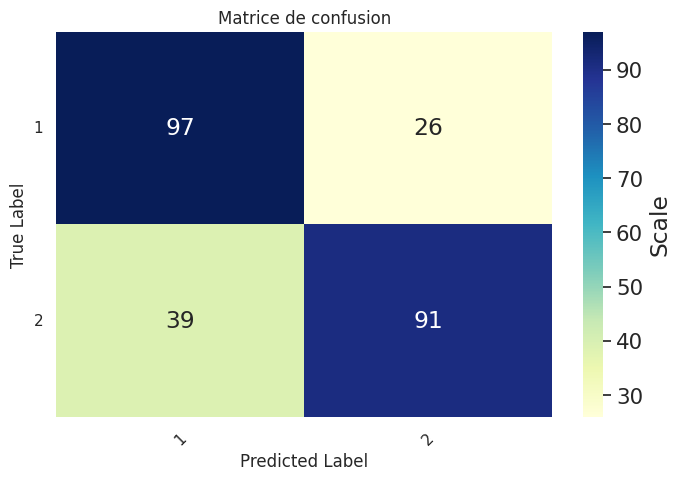

Ensemble des meilleurs paramètres :
	svm__C: 10
	svm__gamma: 0.001
	svm__kernel: 'linear'

Les premiers résultats : 
     svm__C  svm__gamma svm__kernel  accuracy
68    10.0       0.010      linear  0.774229
76    10.0       1.000      linear  0.774229
72    10.0       0.100      linear  0.774229
64    10.0       0.001      linear  0.774229
77    10.0       1.000         rbf  0.774214


In [ ]:
# Création du jeu d'apprentissage et de test
X = df_all['text']
y = df_all['classe']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import pandas as pd
import time

# création du pipeline
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ('svm', SVC())
])

# création des différents paramètres à tester pour SVM
parameters = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10],
    'svm__gamma' : [0.001, 0.01, 0.1, 1],
    'svm__kernel': ['linear','rbf','poly','sigmoid']
}

score = 'accuracy'

# Application de gridsearchcv, n_jobs=-1 permet de pouvoir utiliser plusieurs CPU
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring=score)
print("Application de gridsearch ...")
print("pipeline :", [name for name, _ in pipeline.steps])
print("parameters :")
print(parameters)
start_time = time.time()
grid_search.fit(X_train, y_train)
print("réalisé en %0.3f s" % (time.time() - start_time))
print("Meilleur résultat : %0.3f" % grid_search.best_score_)

# autres mesures et matrice de confusion
y_pred = grid_search.predict(X_test)
MyshowAllScores(y_test, y_pred)
print("Ensemble des meilleurs paramètres :")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

# Affichage des premiers résultats du gridsearch
df_results=pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
 pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=[score])],axis=1).sort_values(score,ascending=False)
print ("\nLes premiers résultats : \n",df_results.head())

**Généralisation du traitement sur le texte avec pipline** 



Accuracy: 0.7455621301775148
Precision: 0.71875
Recall: 0.8117647058823529
F1 score: 0.7624309392265194
              precision    recall  f1-score   support

           1       0.72      0.81      0.76        85
           2       0.78      0.68      0.73        84

    accuracy                           0.75       169
   macro avg       0.75      0.75      0.74       169
weighted avg       0.75      0.75      0.74       169



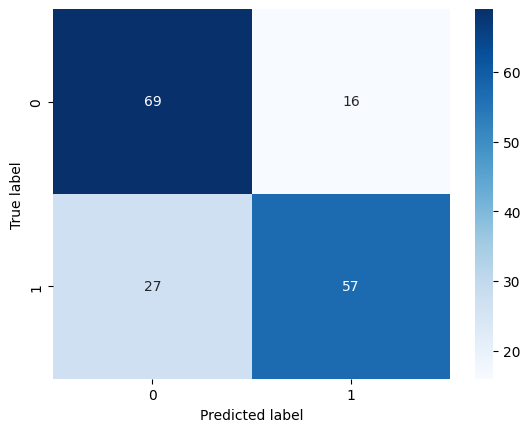

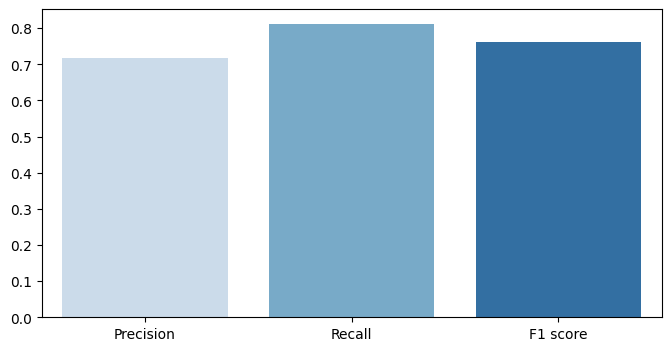

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the pipeline
pipe = Pipeline([
    ("cleaner", TextNormalizer(removestopwords=True, lowercase=True, removedigit=True, getstemmer=False, getlemmatisation=False)),
    ("TfidfVectorizer", TfidfVectorizer()), 
    ("svm", SVC(C=10, gamma=0.001, kernel='linear'))
])

# Define X and y
X = df_all['text']
y = df_all['classe']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipe.fit(X_train, y_train)

# prédire les étiquettes de classe sur l'ensemble de données de test
y_pred = pipe.predict(X_test)

# calculer la précision en comparant les prédictions avec les étiquettes de classe réelles
accuracy = accuracy_score(y_test, y_pred)

# afficher la précision
print("Accuracy:", accuracy)

# calculer les autres mesures
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# afficher les mesures
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

# afficher le rapport de classification
print(classification_report(y_test, y_pred))

# afficher la matrice de confusion sous forme de heatmap
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# afficher les scores de précision, de rappel et de score F1 sous forme de graphe de barres
plt.figure(figsize=(8, 4))
scores = [precision, recall, f1]
sns.barplot(x=['Precision', 'Recall', 'F1 score'], y=scores, palette='Blues')
plt.show()


**Sauvgarde du modele** 

In [29]:
import pickle

try:
    # Enregistrer le pipeline dans un fichier
    with open('model.pkl', 'wb') as file:
        pickle.dump(pipe, file)
except Exception as e:
    print(e)


**Importation du modèle**

Importer et utiliser le modele

Accuracy: 0.778173719376392
Precision: 0.7542277339346111
Recall: 0.7876147869084059
F1 score: 0.7705597788527988
              precision    recall  f1-score   support

           1       0.75      0.79      0.77      4247
           2       0.80      0.77      0.79      4733

    accuracy                           0.78      8980
   macro avg       0.78      0.78      0.78      8980
weighted avg       0.78      0.78      0.78      8980



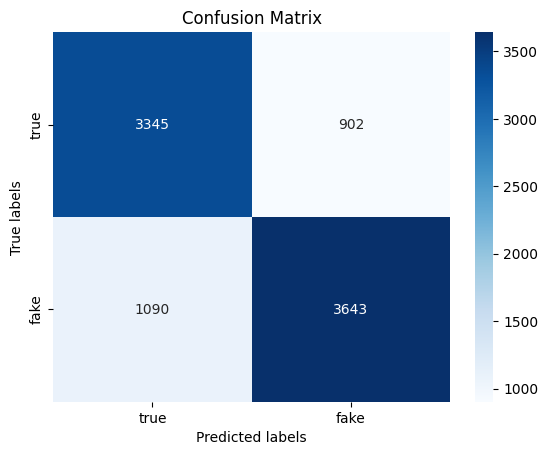

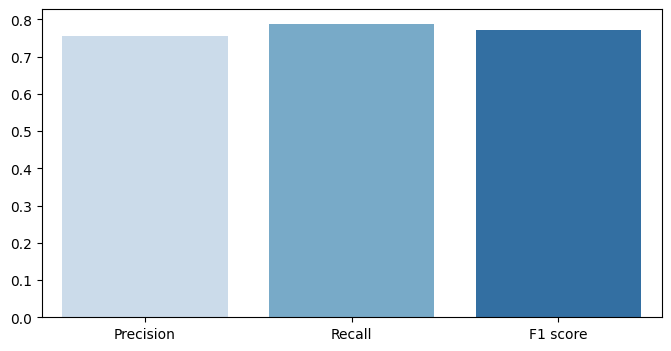

In [30]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Charger le modèle enregistré à partir du fichier 'model.pkl'
with open('model.pkl', 'rb') as file:
    pipe = pickle.load(file)

# Charger les données
df_fake = pd.read_csv('/content/drive/MyDrive/ML/Fake.csv')
df_true = pd.read_csv('/content/drive/MyDrive/ML/True.csv')

# Ajouter les étiquettes de classe aux données
df_fake["class"] = 2
df_true["class"] = 1

# Concaténer les données
df = pd.concat([df_fake, df_true])

# Préparer les données pour la prédiction en séparant les caractéristiques (X) et les étiquettes de classe (y)
X = df['text']
y = df['class']

# diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# prédire les étiquettes de classe sur l'ensemble de données de test
y_pred = pipe.predict(X_test)

# calculer la précision en comparant les prédictions avec les étiquettes de classe réelles
accuracy = accuracy_score(y_test, y_pred)

# calculer les autres mesures
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# afficher les mesures
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

# afficher le rapport de classification
print(classification_report(y_test, y_pred))

# afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['true', 'fake'])
ax.yaxis.set_ticklabels(['true', 'fake'])

# afficher les scores de précision, de rappel et de score F1 sous forme de graphe de barres
plt.figure(figsize=(8, 4))
scores = [precision, recall, f1]
sns.barplot(x=['Precision', 'Recall', 'F1 score'], y=scores, palette='Blues')
plt.show()
